In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(224, 224, 3)) # width, height, channels
# x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(8, activation="softmax")(x) # 8 classes in AffectNet
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 109, 109, 64)      18496     
                                                           

In [3]:
train_img_dir = '/home/lndr/Development/FER/AffectNet_sorted/train_set'
test_img_dir = '/home/lndr/Development/FER/AffectNet_sorted/val_set'

In [4]:
import random

def load_data(train_img_dir, test_img_dir):

    train_dataset = tf.keras.utils.image_dataset_from_directory(
        train_img_dir,
        labels='inferred',
        label_mode='int',
        color_mode='rgb',
        batch_size=32,
        image_size=(224, 224),
        shuffle=True,
        seed=random.randint(0,1000),
        validation_split=0.2,
        subset='both'
    )

    test_dataset = tf.keras.utils.image_dataset_from_directory(
        test_img_dir,
        labels='inferred',
        label_mode='int',
        color_mode='rgb',
        batch_size=32,
        image_size=(224, 224),
        shuffle=True,
        seed=random.randint(0,1000),
        validation_split=None
    )

    return train_dataset, test_dataset

In [5]:
(train_dataset, val_dataset), test_dataset = load_data(train_img_dir, test_img_dir)

Found 287651 files belonging to 8 classes.
Using 230121 files for training.
Using 57530 files for validation.
Found 3999 files belonging to 8 classes.


In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-6),
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"])

In [10]:
from datetime import date
today = date.today()
date = today.strftime("%Y%m%d")

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=f"{date}_fer_convnet_scratch.keras",
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        patience=5)
]

history = model.fit(x=train_dataset, epochs=30, validation_data=val_dataset, callbacks=callbacks)

Epoch 1/30
7192/7192 [==============================] - 336s 46ms/step - loss: 1.4893 - accuracy: 0.4661 - val_loss: 1.4535 - val_accuracy: 0.4726
Epoch 2/30
7192/7192 [==============================] - 334s 46ms/step - loss: 1.4449 - accuracy: 0.4756 - val_loss: 1.4104 - val_accuracy: 0.4915
Epoch 3/30
7192/7192 [==============================] - 335s 47ms/step - loss: 1.3914 - accuracy: 0.4982 - val_loss: 1.3238 - val_accuracy: 0.5436
Epoch 4/30
7192/7192 [==============================] - 318s 44ms/step - loss: 1.3380 - accuracy: 0.5276 - val_loss: 1.2663 - val_accuracy: 0.5652
Epoch 5/30
7192/7192 [==============================] - 331s 46ms/step - loss: 1.3053 - accuracy: 0.5436 - val_loss: 1.2336 - val_accuracy: 0.5736
Epoch 6/30
7192/7192 [==============================] - 327s 45ms/step - loss: 1.2818 - accuracy: 0.5546 - val_loss: 1.2128 - val_accuracy: 0.5810
Epoch 7/30
7192/7192 [==============================] - 326s 45ms/step - loss: 1.2643 - accuracy: 0.5611 - val_loss: 1

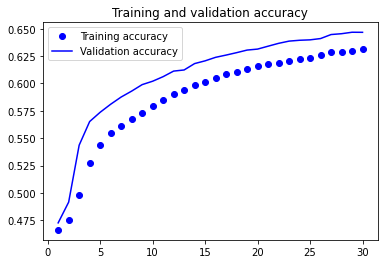

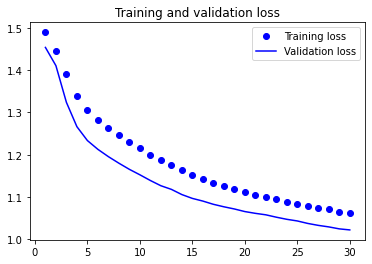

In [11]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [12]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

125/125 [==============================] - 3s 21ms/step - loss: 2.2572 - accuracy: 0.2771
Test accuracy: 0.277
